# Dispersion fitting tool

Here we show how to fit optical measurement data and use the results to create dispersion material models for Tidy3d.

Tidy3D's dispersion fitting tool peforms an optimization to find a medium defined as a dispersive [PoleResidue](../_autosummary/tidy3d.PoleResidue.rst) model that minimizes the RMS error between the model results and the data. This can then be directly used as a material in simulations.

In [1]:
# first import packages
import matplotlib.pylab as plt
import numpy as np

import tidy3d as td


[21:30:34] WARNING  This version of Tidy3D was pip installed from the 'tidy3d-beta' repository on   ]8;id=486318;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=46774;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#103\103]8;;\
                    PyPI. Future releases will be uploaded to the 'tidy3d' repository. From now on,                
                    please use 'pip install tidy3d' instead.                                                       

           INFO     Using client version: 1.9.0rc1                                                  ]8;id=941476;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=871531;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#121\121]8;;\

## Load Data

The fitting tool accepts three ways of loading data:

1. Numpy arrays directly by specifying `wvl_um`, `n_data`, and optionally `k_data`;

2. Data file with the `from_file` utility function.

    Our data file has columns for wavelength (um), real part of refractive index (n), and imaginary part of refractive index (k).  k data is optional. 
    
    Note: `from_file` uses [np.loadtxt](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html) under the hood, so additional keyword arguments for parsing the file follow the same format as [np.loadtxt](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html).
    
3. URL linked to a csv/txt file that contains wavelength (micron), n, and optionally k data with the `from_url` utility function. URL can come from [refractiveindex](https://refractiveindex.info).

Below the 2nd way is taken as an example:

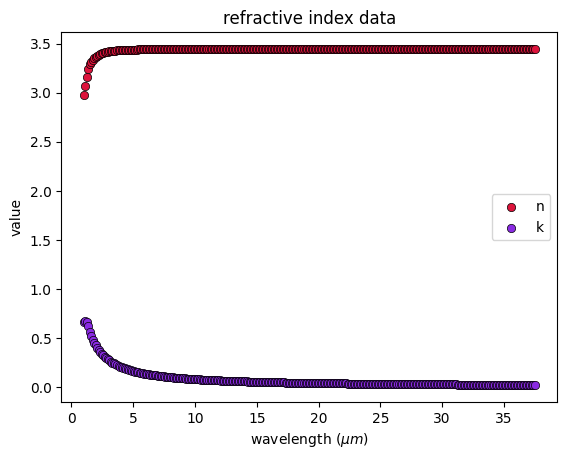

In [2]:
from tidy3d.plugins import DispersionFitter

fname = "data/nk_data.csv"

# note that additional keyword arguments to load_nk_file get passed to np.loadtxt
fitter = DispersionFitter.from_file(fname, skiprows=1, delimiter=",")

# lets plot the data
plt.scatter(
    fitter.wvl_um,
    fitter.n_data,
    label="n",
    color="crimson",
    edgecolors="black",
    linewidth=0.5,
)
plt.scatter(
    fitter.wvl_um,
    fitter.k_data,
    label="k",
    color="blueviolet",
    edgecolors="black",
    linewidth=0.5,
)
plt.xlabel("wavelength ($\mu m$)")
plt.ylabel("value")
plt.title("refractive index data")
plt.legend()
plt.show()


## Fitting the data

The fitting tool fit a dispersion model to the data by minimizing the root mean squared (RMS) error between the model n,k prediciton and the data at the given wavelengths.

There are various fitting parameters that can be set, but the most important is the number of "poles" in the model.

For each pole, there are 4 degrees of freedom in the model.  Adding more poles can produce a closer fit, but each additional pole added will make the fit harder to obtain and will slow down the FDTD.  Therefore, it is best to try the fit with few numbers of poles and increase until the results look good.

Here, we will first try fitting the data with 1 pole and specify the RMS value that we are happy with (`tolerance_rms`).

Note that the fitting tool performs global optimizations with random starting coefficients, and will repeat the optimization `num_tries` times, returning either the best result or the first result to satisfy the tolerance specified.

In [3]:
medium, rms_error = fitter.fit(num_poles=1, tolerance_rms=2e-2, num_tries=100)


Output()

[21:30:42] WARNING          warning: did not find fit with RMS error under tolerance_rms of 2.00e-02     ]8;id=508975;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/dispersion/fit.py\fit.py]8;;\:]8;id=309901;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/dispersion/fit.py#364\364]8;;\

           INFO             returning best fit with RMS error 9.95e-02                                   ]8;id=505127;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/dispersion/fit.py\fit.py]8;;\:]8;id=545074;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/dispersion/fit.py#368\368]8;;\

The RMS error stalled at a value that was far above our tolerance, so we might want to try more fits.

Let's first visualize how well the best single pole fit captured our model using the `.plot()` method

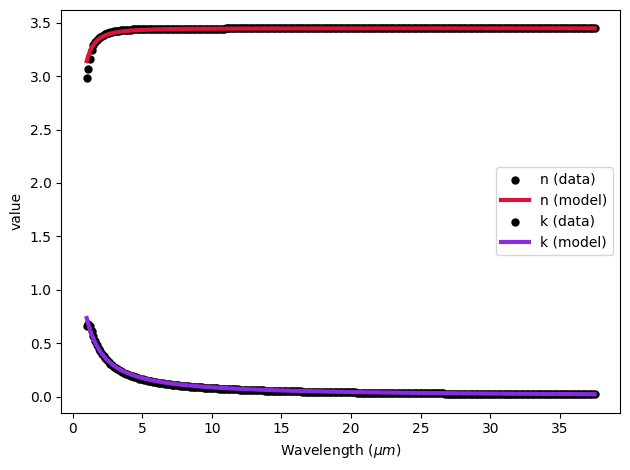

In [4]:
fitter.plot(medium)
plt.show()


As we can see, there is room for improvement at short wavelengths. Let's now try a two pole fit.

In [5]:
medium, rms_error = fitter.fit(num_poles=2, tolerance_rms=2e-2, num_tries=50)


Output()

[21:31:00] INFO             found optimal fit with RMS error = 1.90e-02, returning                       ]8;id=202944;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/dispersion/fit.py\fit.py]8;;\:]8;id=76605;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/dispersion/fit.py#360\360]8;;\
best RMS error so far: 2.06e-02 ━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━  66% 0:00:09

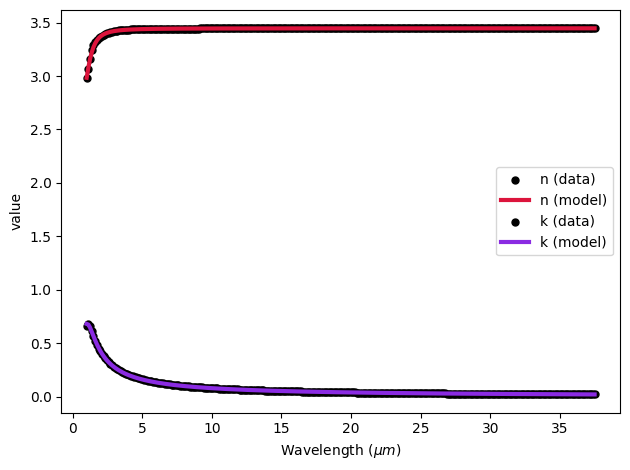

In [6]:
fitter.plot(medium)
plt.show()


This fit looks great and should be sufficient for our simulation.

Alternatively, if the simulation is narrowband, you might want to truncate your data to not include wavelengths far outside your measurement wavelength to simplify the dispersive model. This is through modifying the attribute `wvl_range` where you can set the lower wavelength bound `wvl_range[0]` and the higher wavelength bound `wvl_range[1]`. This operation is non-destructive, so you can always unset them by setting the value to `None`. 

E.g. if we are only interested in the wavelength 3-20 um, we can still use the single-pole model:

In [7]:
fitter = fitter.copy(update={"wvl_range": (3, 20)})
medium, rms_error = fitter.fit(num_poles=1, tolerance_rms=2e-2, num_tries=100)


Output()

           INFO             found optimal fit with RMS error = 1.11e-02, returning                       ]8;id=508462;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/dispersion/fit.py\fit.py]8;;\:]8;id=467141;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/dispersion/fit.py#360\360]8;;\
Fitting with 1 to RMS of 0.02... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

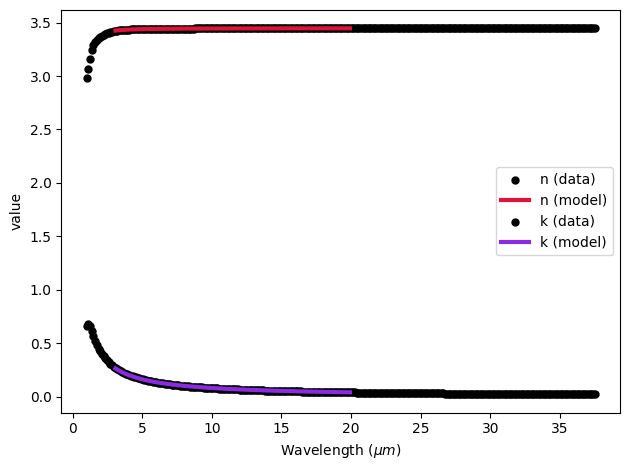

In [8]:
fitter.plot(medium)
plt.show()


## Using Fit Results

With the fit performed, we want to use the `Medium` in our simulation.


### Method 1: direct export as Medium

The fit returns a medium, which can be used directly in simulation

In [9]:
b = td.Structure(geometry=td.Box(size=(1, 1, 1)), medium=medium)


### Method 2: print medium definition string

In many cases, one may want to perform the fit once and then hardcode the result in their tidy3d script.

For a quick and easy way to do this, just `print()` the medium and the output can be copied and pasted into your main svript

In [10]:
print(medium)


td.PoleResidue(
	eps_inf=1.0, 
	poles=(((-3464409493588389.5-2236414374514880.5j), (1.2412679745347164e+16+2.2143174665138764e+16j)),), 
	frequency_range=(15048764551236.16, 97485556664009.75))


In [11]:
# medium = td.PoleResidue(
# 	poles=[((-1720022108564405.2, 1111614865738177.4), (1.0199002935090378e+16, -3696384150818460.5)), ((0.0, -3100558969639478.5), (3298054971521434.5, 859192377978951.2))],
# 	frequency_range=(7994465562158.582, 299792458580946.8))


### Method 3: save and load file containing poles

Finally, one can save export the `Medium` directly as .json file. Here is an example.

In [12]:
# save poles to pole_data.txt
fname = "data/my_medium.json"
medium.to_file(fname)

# load the file in your script
medium = td.PoleResidue.from_file(fname)


## Tricks and Tips / Troubleshooting

Performing dispersion model fits is more of an art than a science and some trial and error may be required to get good fits.  A good general strategy is to:

- Start with few poles and increase unitl RMS error gets to the desired level.

- Large `num_tries` values can sometimes find good fits if the RMS seems stalled.  it can be a good idea to set a large number of tries and let it run for a while on an especially difficult data model.

- Tailor the parameters to your data.  Long wavelengths and large n,k values can affect the RMS error that is considered a 'good' fit.  So it is a good idea to tweak the tolerance to match your data.  Once size does not fit all.

Finally, there are some things to be aware of when troubleshooting the dispersion models in your actaual simulation:

- If you are unable to find a good fit to your data, it might be worth considering whether you care about certain features in the data.  For example as shown above, if the simulation is narrowband, you might want to truncate your data to not include wavelengths far outside your measurement wavelength to simplify the dispersive model.

- It is common to find divergence in FDTD simulations due to dispersive materials.  Besides trying "absorber" PML types and reducing runtime, a good solution can be to try other fits, or to explore our new `StableFitter` feature which will be explained below.


# Stable fitter

We recently introduced a version of the `DispersionFitter` tool that implements our proprietary stability criterion.  We observe consistently stable FDTD simulations when materials are fit using this method and also provide it in the newest versions of Tidy3d.

Functionally speaking, it works identically to the previously introduced tool, excpet the `.fit()` method is run on Flexcompute servers and therefore this tool reqiures signing in to a Tidy3D account. Here is a demonstration.

In [13]:
from tidy3d.plugins import StableDispersionFitter, AdvancedFitterParam

fname = "data/nk_data.csv"
fitter_stable = StableDispersionFitter.from_file(fname, skiprows=1, delimiter=",")


In [14]:
medium, rms_error = fitter_stable.fit(
    num_poles=2,
    tolerance_rms=2e-2,
    num_tries=50,
    advanced_param=AdvancedFitterParam(nlopt_maxeval=10000),
)


           INFO     Using Tidy3D credentials from stored file.                                           ]8;id=236078;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py\auth.py]8;;\:]8;id=928196;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py#70\70]8;;\

[21:31:02] INFO     Authentication successful.                                                           ]8;id=722948;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py\auth.py]8;;\:]8;id=300565;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py#30\30]8;;\

[21:31:17] INFO             found optimal fit with RMS error = 1.71e-02, returning                   ]8;id=692585;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/dispersion/fit_web.py\fit_web.py]8;;\:]8;id=745987;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/dispersion/fit_web.py#316\316]8;;\

Note here we supply the `advanced_param` for more control of the fitting process. `nlopt_maxeval` stands for the maximal number of iterations for each inner optimization. Details of a list of other advanced parameters will be explained later.

We can visualize our fits the same way.

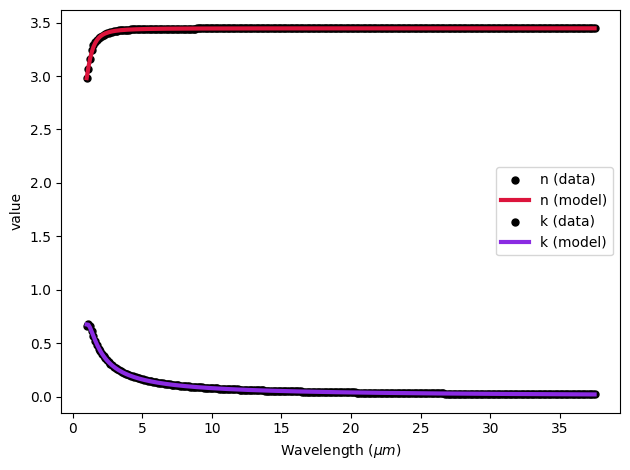

In [15]:
fitter_stable.plot(medium)
plt.show()


Once the fitting is performed, the procedure of using the medium in our simulation is also idential to the previous fitting tool, which we will not go into details here.

## Tips

- Our stable fitter is based on a web service, and therefore it can run into `timeout` errors if the fitter runs for too long. In this case, you are encouraged to decrease the value of `num_tries` or to relax the value of `tolerance_rms` to your needs.

- Our fitting tool performs global optimizations with random starting coefficients, and will repeat the optimization `num_tries` times. Within each inner optimization, the maximal number of iterations is bounded by an  **advanced parameter** `nlopt_maxeval` whose default value is `5000`. Since there is a well-known tradeoff between exploration and exploitation in a typical global optimization process, you can play around with `num_tries` and `nlopt_maxeval`. In particular in senarios where `timeout` error occurs and decreasing `num_tries` leads to larger RMS error, you can try to decrease `nlopt_maxeval`.

A list of other advanced parameters can be found in our documentation. For example:

- In cases where the permittivity at inifinity frequency is other than 1, it can also be optimized by setting an **advanced parameter** `bound_eps_inf` so that the permittivity at infinite frequency can take values between `[1,bound_eps_inf]`.

- Sometimes we want to bound the pole frequency in the dispersive model. The lower and upper bound can be set with `bound_f_lower` and `bound_f`, respectively.

- The fitting tool performs global optimizations with random starting coefficients. By default, the value of the seed `rand_seed=0` is fixed, so that you'll obtain identical results when re-running the fitter. If you want to re-run the fitter several times to obtain the best results, the value of the seed should be changed, or set to  `None` so that the starting coefficients are different each time. 